### Load the required libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision import datasets
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
import numpy as np
from sklearn.metrics import confusion_matrix
import pandas as pd
from tqdm import tqdm

In [2]:
# Convert the data to Tensor
transform = transforms.ToTensor()

### Load FashionMNIST dataset

The data is stored in the folder specified at `root`

In [3]:
train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

### Create the dataloaders

In [4]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

### Define the MLP model

In [5]:
class FashionNN(nn.Module):
    """
    A simple neural network for classifying FashionMNIST Images. The network has 2 fully connected layers with ReLU activation and
    a final layer with 10 output categories.
    """
    def __init__(self, hidden_dim):
        super(FashionNN, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28 * 28, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.final_layer = nn.Linear(hidden_dim, 10)

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.final_layer(x)
        
        return x

### Training function

In [6]:
def train_nn(model, train_loader, criterion, optimizer, device):
    """Function to train the neural network for one epoch"""
    model.train()
    running_loss = 0.0
    correct_labels = 0
    total_labels = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        predicted_labels = torch.argmax(outputs, dim=1)
        total_labels += labels.size(0)
        correct_labels += torch.sum(predicted_labels == labels).item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = correct_labels / total_labels
    
    return train_loss, train_accuracy

### Evaluation function

In [7]:
def evaluate_nn(model, test_loader, criterion, device):
    """
    Function to evaluate the neural network on the test data.
    """
    model.eval()
    running_loss = 0.0
    correct_labels = 0
    total_labels = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            predicted_labels = torch.argmax(outputs, dim=1)
            total_labels += labels.size(0)
            correct_labels += torch.sum(predicted_labels == labels).item()

    test_loss = running_loss / len(test_loader)
    test_accuracy = correct_labels / total_labels
    return test_loss, test_accuracy

### Main training loop

In [8]:
def run_training(hidden_dim, lr, num_epochs):
    """
    Function to train and evaluate the model for a given number of epochs.
    """

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = FashionNN(hidden_dim).to(device)                    # Initialize model
    criterion = nn.CrossEntropyLoss()                           # Loss function
    optimizer = optim.Adam(model.parameters(), lr=lr)            # Optimizer

    train_losses = []
    test_losses = []
    
    train_accuracies = []
    test_accuracies = []

    # Training loop
    for epoch in tqdm(range(num_epochs)):
        train_loss, train_accuracy = train_nn(model, train_loader, criterion, optimizer, device)
        test_loss, test_accuracy = evaluate_nn(model, test_loader, criterion, device)

        train_losses.append(train_loss)
        test_losses.append(test_loss)
        
        train_accuracies.append(train_accuracy)
        test_accuracies.append(test_accuracy)

        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}")
        print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_accuracy:.4f}")

    # Returns the model metrics.
    return model, train_losses, train_accuracies, test_losses, test_accuracies

### Run the training

In [9]:
hidden_dim = 128
lr = 0.001
num_epochs = 12

# Call the model training function
model, train_losses, train_accuracies, test_losses, test_accuracies = run_training(hidden_dim, lr, num_epochs)


  8%|████▋                                                   | 1/12 [00:09<01:40,  9.16s/it]

Epoch 1/12
Train Loss: 0.5076, Train Acc: 0.8184
Test Loss: 0.4124, Test Acc: 0.8553


 17%|█████████▎                                              | 2/12 [00:18<01:33,  9.37s/it]

Epoch 2/12
Train Loss: 0.3720, Train Acc: 0.8639
Test Loss: 0.4029, Test Acc: 0.8598


 25%|██████████████                                          | 3/12 [00:28<01:25,  9.53s/it]

Epoch 3/12
Train Loss: 0.3347, Train Acc: 0.8764
Test Loss: 0.3824, Test Acc: 0.8621


 33%|██████████████████▋                                     | 4/12 [00:38<01:19,  9.95s/it]

Epoch 4/12
Train Loss: 0.3111, Train Acc: 0.8864
Test Loss: 0.3711, Test Acc: 0.8634


 42%|███████████████████████▎                                | 5/12 [00:49<01:10, 10.10s/it]

Epoch 5/12
Train Loss: 0.2948, Train Acc: 0.8904
Test Loss: 0.3494, Test Acc: 0.8743


 50%|████████████████████████████                            | 6/12 [00:59<01:00, 10.11s/it]

Epoch 6/12
Train Loss: 0.2792, Train Acc: 0.8950
Test Loss: 0.3337, Test Acc: 0.8788


 58%|████████████████████████████████▋                       | 7/12 [01:09<00:50, 10.10s/it]

Epoch 7/12
Train Loss: 0.2676, Train Acc: 0.8994
Test Loss: 0.3707, Test Acc: 0.8736


 67%|█████████████████████████████████████▎                  | 8/12 [01:19<00:40, 10.10s/it]

Epoch 8/12
Train Loss: 0.2567, Train Acc: 0.9031
Test Loss: 0.3312, Test Acc: 0.8828


 75%|██████████████████████████████████████████              | 9/12 [01:29<00:30, 10.11s/it]

Epoch 9/12
Train Loss: 0.2452, Train Acc: 0.9067
Test Loss: 0.3268, Test Acc: 0.8824


 83%|█████████████████████████████████████████████▊         | 10/12 [01:39<00:20, 10.12s/it]

Epoch 10/12
Train Loss: 0.2360, Train Acc: 0.9108
Test Loss: 0.3507, Test Acc: 0.8767


 92%|██████████████████████████████████████████████████▍    | 11/12 [01:50<00:10, 10.14s/it]

Epoch 11/12
Train Loss: 0.2262, Train Acc: 0.9150
Test Loss: 0.3764, Test Acc: 0.8680


100%|███████████████████████████████████████████████████████| 12/12 [02:00<00:00, 10.03s/it]

Epoch 12/12
Train Loss: 0.2194, Train Acc: 0.9165
Test Loss: 0.3468, Test Acc: 0.8806


### Plot model metric curves

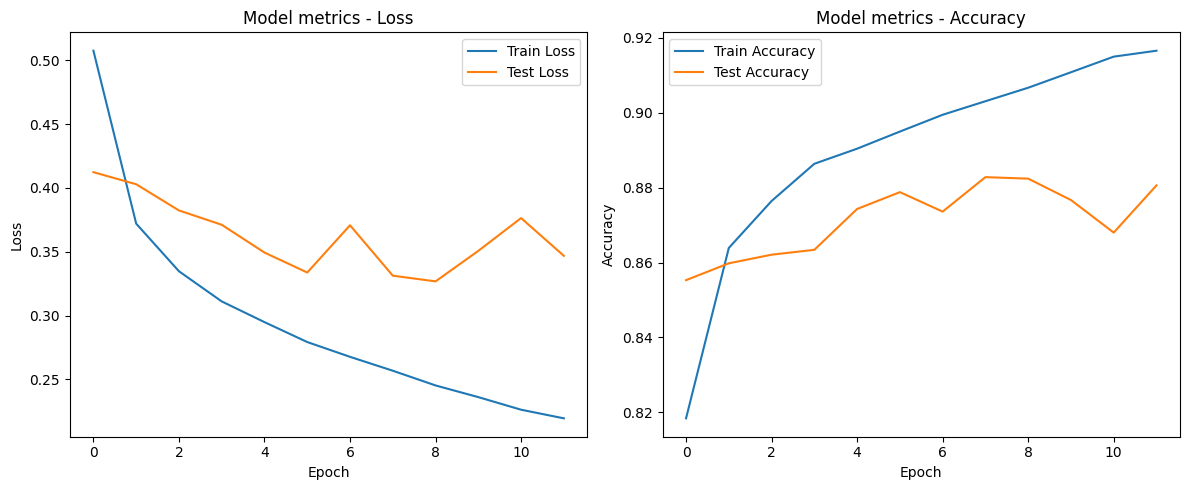

In [11]:
# plt.style.use('seaborn-v0_8-whitegrid')

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Model metrics - Loss')

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model metrics - Accuracy')
plt.tight_layout()
plt.show()

In the first graph we see that test loss first decreases and then starts increasing after a given epoch(between 12 and 15), this shows that the model is now overfitting on the data

In [12]:
# Function to get predictions and true labels
def get_predictions(model, loader, device):
    model.eval()
    all_predictions = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            predictions = torch.argmax(outputs, dim=1)
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return np.array(all_predictions), np.array(all_labels)


In [13]:
# Get predictions
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
y_pred, y_true = get_predictions(model, test_loader, device)

### Plot confusion matrix

In [14]:
label_names = [
    'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
    'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'
]

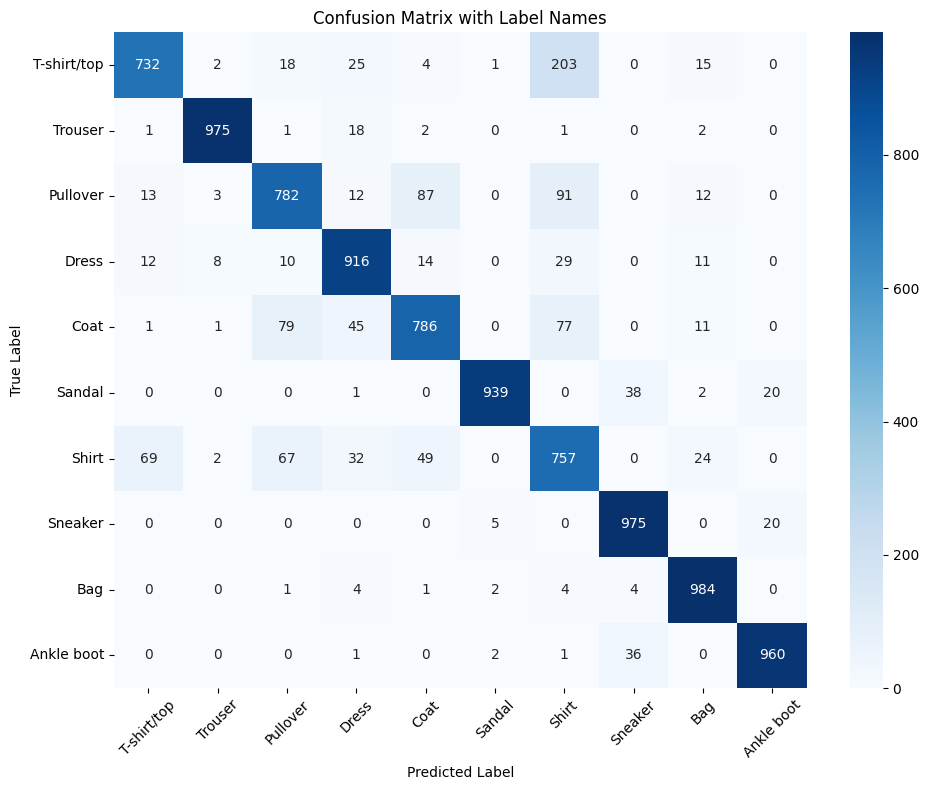

In [15]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_names, yticklabels=label_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix with Label Names')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [16]:
def plot_images_with_predictions(model, loader, device, num_images=10, label_names=None):
    """
    Function to visualize test dataset predictions in a 2D grid format.
    """
    model.eval()
    images, labels = next(iter(loader))
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    preds = torch.argmax(outputs, dim=1)

    fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(12, 10))  # Create a 2x5 grid for the images
    idx = 0

    for i in range(2):
        for j in range(5):
            if idx >= num_images:
                break
            
            img = images[idx].cpu().squeeze().numpy()  # Get image
            true_label = label_names[labels[idx].item()]  # Get true label
            pred_label = label_names[preds[idx].item()]  # Get predicted label
            
            ax[i, j].set_title(f"True: {true_label}\nPred: {pred_label}")
            ax[i, j].imshow(img, cmap='gray')
            ax[i, j].axis('off')
            idx += 1

    plt.tight_layout()
    plt.suptitle("Test Dataset Predictions", fontsize=20)
    plt.show()

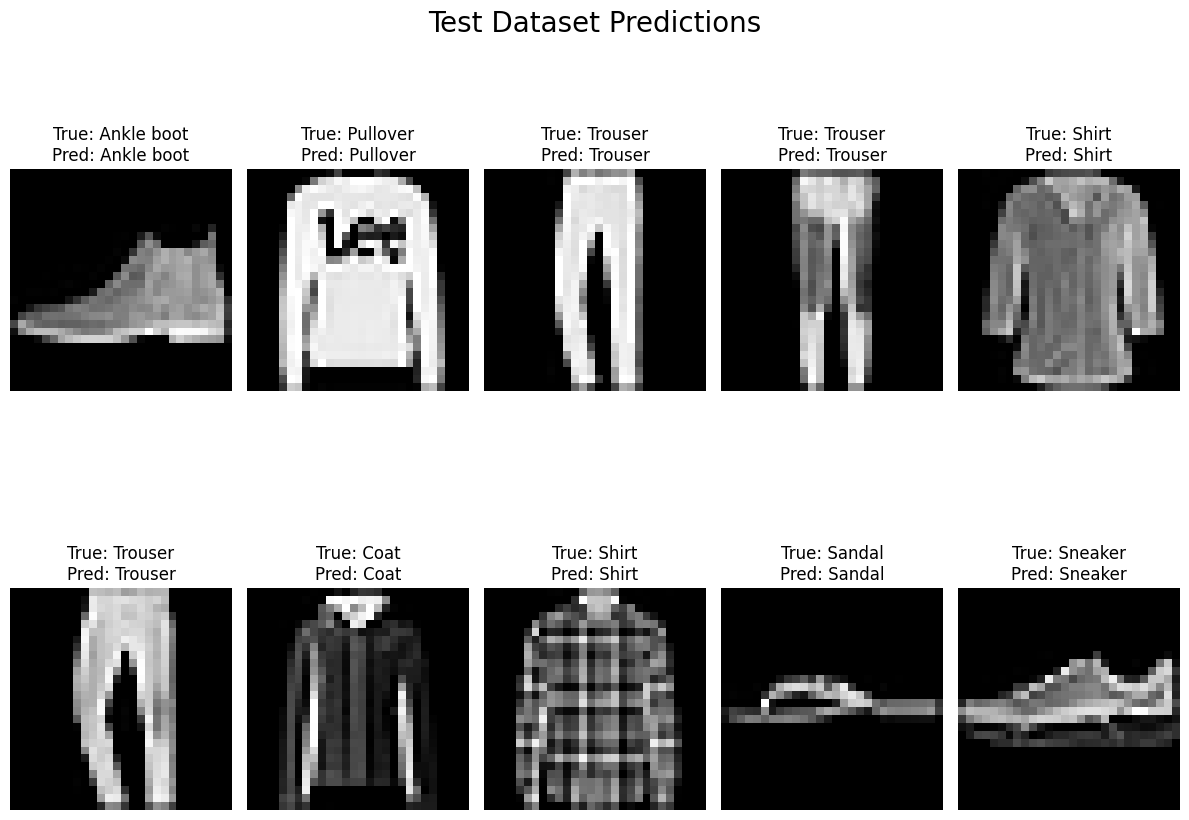

In [17]:
plot_images_with_predictions(model, test_loader, device, num_images=10, label_names=label_names)

In [18]:
def plot_wrong_predictions(model, loader, device, label_names=None, num_images=10):
    """
    Function to visualize wrong predictions.
    """
    model.eval()
    images, labels = next(iter(loader))
    images, labels = images.to(device), labels.to(device)
    
    # Get model outputs and predictions
    outputs = model(images)
    preds = torch.argmax(outputs, dim=1)

    # Find incorrect predictions
    wrong_idx = np.where(preds != labels)[0]
    

    fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(12, 10))  # 2x5 grid for wrong predictions
    idx = 0

    for i in range(2):
        for j in range(5):
            if idx >= num_images:
                break
            
            # Select random wrong prediction
            wrong_index = np.random.choice(wrong_idx)
            img = images[wrong_index].cpu().squeeze().numpy()
            true_label = label_names[labels[wrong_index].item()]
            pred_label = label_names[preds[wrong_index].item()]
            
            ax[i, j].set_title(f"True: {true_label}\nPred: {pred_label}")
            ax[i, j].imshow(img, cmap='gray')
            ax[i, j].axis('off')
            idx += 1

    plt.tight_layout()
    plt.suptitle('Wrong Predictions on Test Set', fontsize=20)
    plt.show()

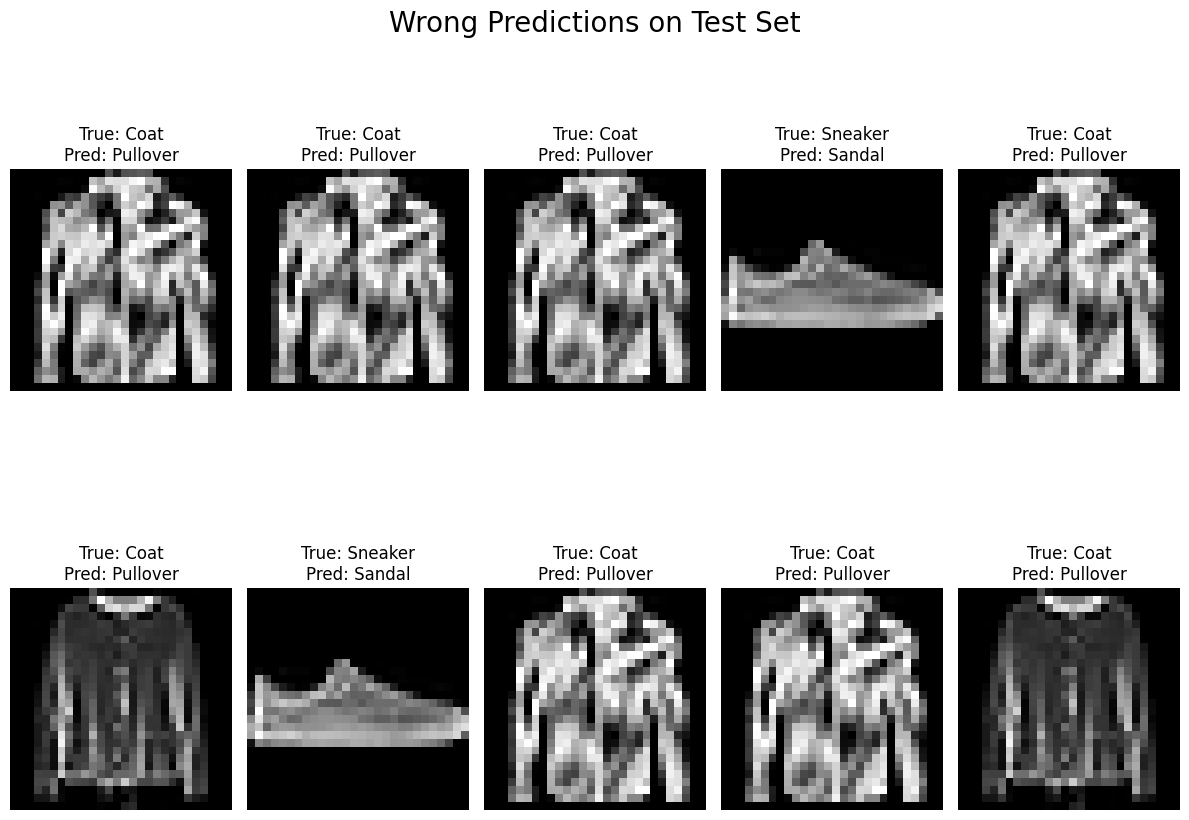

In [19]:
plot_wrong_predictions(model, test_loader, device, label_names=label_names, num_images=10)

As visible from the above plots, wrong predictions mostly occur where the cloting item/apparel categories are highly similar to each other. For e.g. i. sneaker and sandals and ii. coat and pullover. This is because the model is not able to clearly diffrentiate between the clothing items due to their similar appearance and how resolution of the images.

### Hyperparameter tuning with optuna

In [20]:
# Optuna objective function
def objective(trial):
    # Hyperparameters to optimize
    hidden_dims = trial.suggest_int('hidden_dimension', 32, 512)
    lr = trial.suggest_float('lr', 1e-4, 1e-1, log=True)
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'RMSprop', 'SGD'])

    # Create model, loss function, and optimizer
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = FashionNN(hidden_dims).to(device)
    criterion = nn.CrossEntropyLoss()

    if optimizer_name == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=lr)
    elif optimizer_name == 'RMSprop':
        optimizer = optim.RMSprop(model.parameters(), lr=lr)
    else:
        optimizer = optim.SGD(model.parameters(), lr=lr)

    # Training loop
    num_epochs = 10
    for epoch in range(num_epochs):
        train(model, train_loader, criterion, optimizer, device)

    # Evaluate the model
    _, test_acc = evaluate(model, test_loader, criterion, device)
    
    return test_acc

In [21]:
def objective(trial):
    hidden_dim = trial.suggest_int('hidden_dimension', 28, 288)
    lr = trial.suggest_float('learning_rate', 1e-4, 1e-1, log=True)
    # optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'RMSprop', 'SGD'])
    
    model, _, _, _, _ = run_training(hidden_dim, lr, num_epochs=5)
    _, test_acc = evaluate(model, test_loader, nn.CrossEntropyLoss(), device)
    
    return test_acc

In [22]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

[I 2024-10-21 21:41:16,923] A new study created in memory with name: no-name-2007f513-36f8-4a2c-bdd7-864ae68d2d3f
 20%|███████████▍                                             | 1/5 [00:11<00:45, 11.31s/it]

Epoch 1/5
Train Loss: 0.6241, Train Acc: 0.7843
Test Loss: 0.5370, Test Acc: 0.8187


 40%|██████████████████████▊                                  | 2/5 [00:23<00:35, 11.89s/it]

Epoch 2/5
Train Loss: 0.5200, Train Acc: 0.8260
Test Loss: 0.5481, Test Acc: 0.8160


 60%|██████████████████████████████████▏                      | 3/5 [00:36<00:24, 12.15s/it]

Epoch 3/5
Train Loss: 0.5049, Train Acc: 0.8306
Test Loss: 0.5153, Test Acc: 0.8343


 80%|█████████████████████████████████████████████▌           | 4/5 [00:48<00:12, 12.45s/it]

Epoch 4/5
Train Loss: 0.4941, Train Acc: 0.8355
Test Loss: 0.4877, Test Acc: 0.8376


100%|█████████████████████████████████████████████████████████| 5/5 [01:01<00:00, 12.36s/it]
[W 2024-10-21 21:42:18,730] Trial 0 failed with parameters: {'hidden_dimension': 260, 'learning_rate': 0.017491924867616596} because of the following error: NameError("name 'evaluate' is not defined").
Traceback (most recent call last):
  File "/home/ahmad/miniconda3/lib/python3.11/site-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/tmp/ipykernel_27539/3604641848.py", line 7, in objective
    _, test_acc = evaluate(model, test_loader, nn.CrossEntropyLoss(), device)
                  ^^^^^^^^
NameError: name 'evaluate' is not defined
[W 2024-10-21 21:42:18,731] Trial 0 failed with value None.


Epoch 5/5
Train Loss: 0.4748, Train Acc: 0.8414
Test Loss: 0.5371, Test Acc: 0.8166


NameError: name 'evaluate' is not defined

In [ ]:
print("**Best trial results**\n")
trial = study.best_trial
print("Value:", trial.value)
print("Parameters:")
for key, value in trial.params.items():
    print("{}: {}".format(key, value))

In [ ]:
optuna.visualization.plot_param_importances(study)

In [ ]:
optuna.visualization.plot_optimization_history(study)

Objective value in the above graph is the value returned by the objective function. In our case the objective function is maximized in terms of  test accuracy. Whatever configuration gives the highest test accuracy is considered as the best configuration for the model parameters.

### Gradient statistics visualization

In [ ]:
def plot_gradient_stats(model, train_loader, criterion, optimizer, device, num_batches=100):
    model.train()
    grad_norms = []
    grad_maxs = []
    grad_means = []

    for i, (inputs, labels) in enumerate(train_loader):
        if i >= num_batches:
            break

        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()

        total_norm = 0
        max_grad = 0
        mean_grad = 0
        param_count = 0

        for p in model.parameters():
            if p.grad is not None:
                param_norm = p.grad.data.norm(2)
                total_norm += param_norm.item() ** 2
                max_grad = max(max_grad, p.grad.data.abs().max().item())
                mean_grad += p.grad.data.abs().mean().item()
                param_count += 1

        total_norm = total_norm ** 0.5
        mean_grad /= param_count

        grad_norms.append(total_norm)
        grad_maxs.append(max_grad)
        grad_means.append(mean_grad)

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.plot(grad_norms)
    plt.title('Gradient Norm')
    plt.xlabel('Batch')
    plt.ylabel('L2 Norm')

    plt.subplot(1, 3, 2)
    plt.plot(grad_maxs)
    plt.title('Max Gradient')
    plt.xlabel('Batch')
    plt.ylabel('Max Value')

    plt.subplot(1, 3, 3)
    plt.plot(grad_means)
    plt.title('Mean Gradient')
    plt.xlabel('Batch')
    plt.ylabel('Mean Value')

    plt.tight_layout()
    plt.show()

# Plot gradient statistics
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
plot_gradient_stats(model, train_loader, criterion, optimizer, device)

1. The L2 norm of the gradients  measure of the overall "size" or "magnitude" of the gradient across all parameters. It essentially captures how large the updates will be to the model's parameters during backpropagation.
2. The maximum value of the gradient across all parameters in the model.
3. The average of the absolute values of gradients across all parameters in the model.